In [1]:
%matplotlib inline
import pykat
import pykat.optics.ABCD as abcd
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

### My functions
from kat_commands import *
from MMT import *
from cav_commands import *
from load_kat_data import *
import get_WS
import trace_mode

C:\Users\tvo88\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


                                              ..-
    PyKat 1.1.277         _                  '(
                          \`.|\.__...-""""-_." )
       ..+-----.._        /  ' `            .-'
   . '            `:      7/* _/._\    \   (
  (        '::;;+;;:      `-"' =" /,`"" `) /
  L.        \`:::a:f            c_/     n_'
  ..`--...___`.  .    ,
   `^-....____:   +.      www.gwoptics.org/pykat



In [2]:
kat_code = """
# Laser input
l l1 $Pin 0 nin
s s1 0 nin nprc1

# Power recycling mirror
m1 prm $prmT 3.75u $prm_phi nprc1 nprc2
s prc $lprc nprc2 nbsin

# Central beamsplitter
bs bs1 .5 .5 0 45 nbsin n0y n0x nbsout

# X-arm
s ichx $lmichx n0x n1x
m1 itmx $itmT 37.5u 90 n1x n2x
s armx $Larm n2x n3x
m1 etmx 5u 37.5u 89.999875 n3x n4x
attr itmx mass $Mtm zmech sus1
attr etmx mass $Mtm zmech sus1

# Y-arm
s ichy $lmichy n0y n1y
m1 itmy $itmT 37.5u 0.000125  n1y n2y
s army $Larm n2y n3y
m1 etmy 5u 37.5u 0.0035 n3y n4y
attr itmy mass $Mtm zmech sus1
attr etmy mass $Mtm zmech sus1

# Signal recycling mirror
s src $lsrc nbsout nsrc1
m1 srm $srmT 46.2u $srm_phi nsrc1 nsrc2

pd1 asport $fs nsrc2 % photo detector in South port

# Force-to-position transfer function for longitudinal
# motions of test masses
tf sus1 1 0 p $mech_fres $mech_Q
const mech_fres 0.9 # 9 sus-thermal spike
const mech_Q 10M # Guess for suspension Q factor

# DC readout: 100mW = michy_phi 0.07 _or_ darm_phi .00025

const Larm 3994.5
const itmT 0.014
const srmT 0.35
const prmT 0.03
const Pin 125
const Mtm 40
const prm_phi 90
const srm_phi -90
const lmichx 4.5
const lmichy 4.45
const lprc 53.5
const lsrc 50.525

attr itmy Rc -1934
attr etmy Rc 2245

attr itmx Rc -1934
attr etmx Rc 2245

attr prm Rc 11.009
maxtem off
"""

pd_output = """
xaxis etmy phi lin 0 360 100 % changing the microscopic position of mN
"""

darm_commands1 = """
# A squeezed source could be injected into the dark port
#sq sq1 0 0 90 nsrc2
# Differentially modulate the arm lengths
fsig darm armx 1 0
fsig darm2 army 1 180

qnoisedS NSR_with_RP 1 $fs nsrc2
qshotS NSR_without_RP 1 $fs nsrc2
#pdS1 NSR_without_RP1 $fs nsrc2
pd1 pdAS $fs nsrc2

xaxis darm f log 5 5k 500
#yaxis log abs
yaxis abs:deg
"""

In [3]:
### Full Dual Recycled FP Michaelson
basekat = pykat.finesse.kat() 
basekat.parse(kat_code)
basekat.parse(darm_commands1)
basekat.undumpify() #undump the vacuum nodes to get the right quantum noise
kat=basekat.deepcopy() #copy kat code
kat.verbose = False

out = kat.run()

In [4]:
### Turn off SRC, so on PRC FP IFO, to get the phase right takes a lot of work so just use aLIGO design
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

basekat1 = pykat.finesse.kat() 
basekat1.load(katfile)
basekat1.parse(darm_commands)
basekat1.undumpify() #undump the vacuum nodes to get the right quantum noise
kat1=basekat1.deepcopy() #copy kat code
kat1.verbose = False

kat1.SRMHR.T.value = 1.0
kat1.SRMHR.L.value = 0.0
kat1.SRMHR.R.value = 0.0

out1 = kat1.run()

In [5]:
### Turn off PRC and SRC, so only FP IFO
basekat2 = pykat.finesse.kat() 
basekat2.parse(kat_code)
basekat2.parse(darm_commands1)
basekat2.undumpify() #undump the vacuum nodes to get the right quantum noise
kat2=basekat2.deepcopy() #copy kat code
kat2.verbose = False

kat2.prm.T.value = 1.0
kat2.prm.L.value = 0.0
kat2.prm.R.value = 0.0

kat2.srm.T.value = 1.0
kat2.srm.L.value = 0.0
kat2.srm.R.value = 0.0

out2 = kat2.run()

In [6]:
### Advanced LIGO design
katfile = "aLIGO_IFO_AWC_tuning_DCoff_maxtem4_modified.kat" 

basekat3 = pykat.finesse.kat() 
basekat3.load(katfile)
basekat3.parse(darm_commands)
basekat3.undumpify() #undump the vacuum nodes to get the right quantum noise
kat3=basekat3.deepcopy() #copy kat code
kat3.verbose = False

out3 = kat3.run()

In [20]:
kat3.L0.P

<Param (L0.P=125.0) at 0x1865e9d4898>

In [8]:
### Advanced LIGO design + 10 db Squeezing + FC

basekat4 = pykat.finesse.kat() 
basekat4.load(katfile)
basekat4.parse(darm_commands)
basekat4.parse(add_squeezing)
basekat4.undumpify() #undump the vacuum nodes to get the right quantum noise
kat4=basekat4.deepcopy() #copy kat code
kat4.verbose = False

out4 = kat4.run()

In [ ]:
kat3.SRMHR.T.value= 

C:\Users\tvo88\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


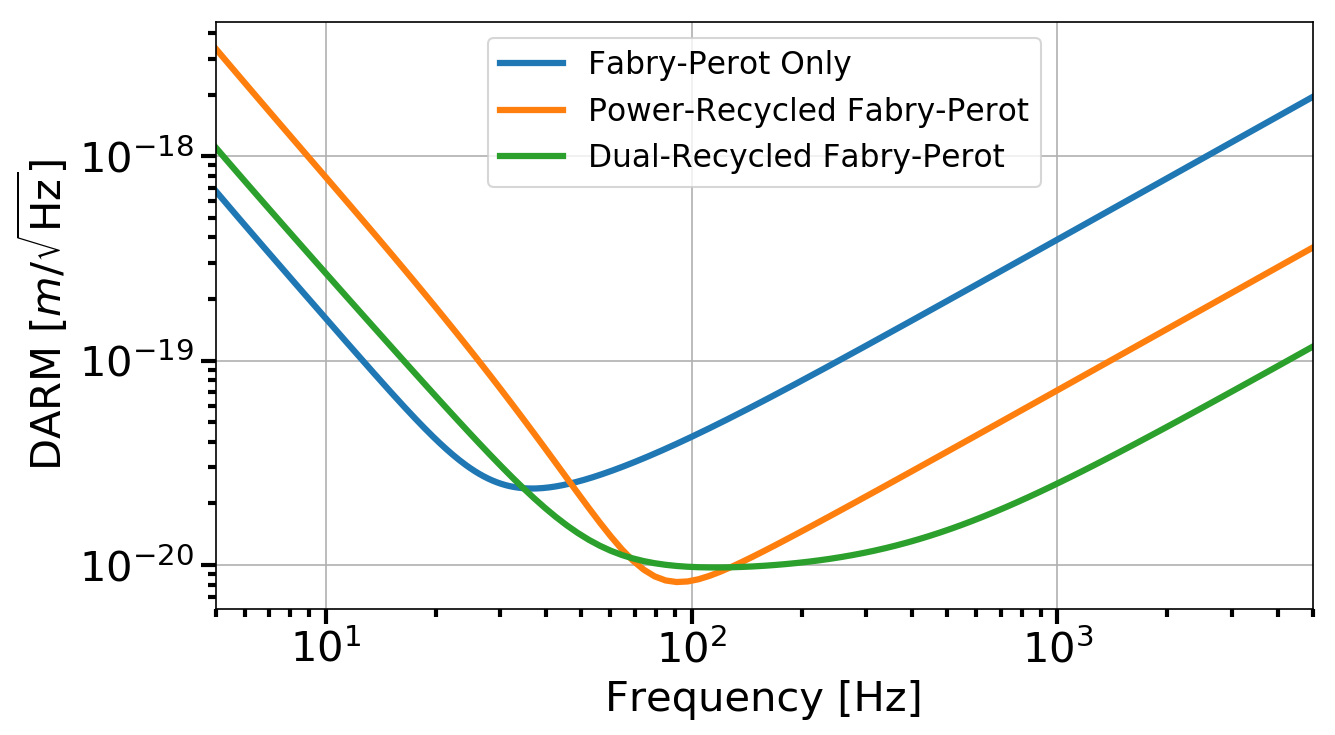

In [21]:
lw=3

pl.figure(figsize=(9, 5), dpi=150)

pl.subplot(111)

#pl.loglog(out.x,4e3*out['NSR_with_RP'],label='Dual-Recycled Fabry-Perot')
pl.loglog(out2.x,4e3*out2['NSR_with_RP'],label='Fabry-Perot Only',linewidth=lw)
pl.loglog(out1.x,4e3*out1['NSR_with_RP'],label='Power-Recycled Fabry-Perot',linewidth=lw)
pl.loglog(out3.x,4e3*out3['NSR_with_RP'],label='Dual-Recycled Fabry-Perot',linewidth=lw)
#pl.loglog(out4.x,4e3*out4['NSR_with_RP'],label='Dual-Recycled Fabry-Perot + 10db Sqz + FC')

pl.legend(fontsize=15)

pl.xlim(out.x.min(),out.x.max())
pl.xlabel("Frequency [Hz]",fontsize=20)
pl.ylabel("DARM [$m/\\sqrt{\mathrm{Hz}}$]",fontsize=20)

#pl.title('Quantum-Limited Differential Arm Sensitivity',fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
#pl.ylim(5e-21,1e-18)


pl.tight_layout()
pl.savefig('../../../Figures/QM_Limited_Sense.png')

C:\Users\tvo88\Anaconda3\lib\site-packages\numpy\core\numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


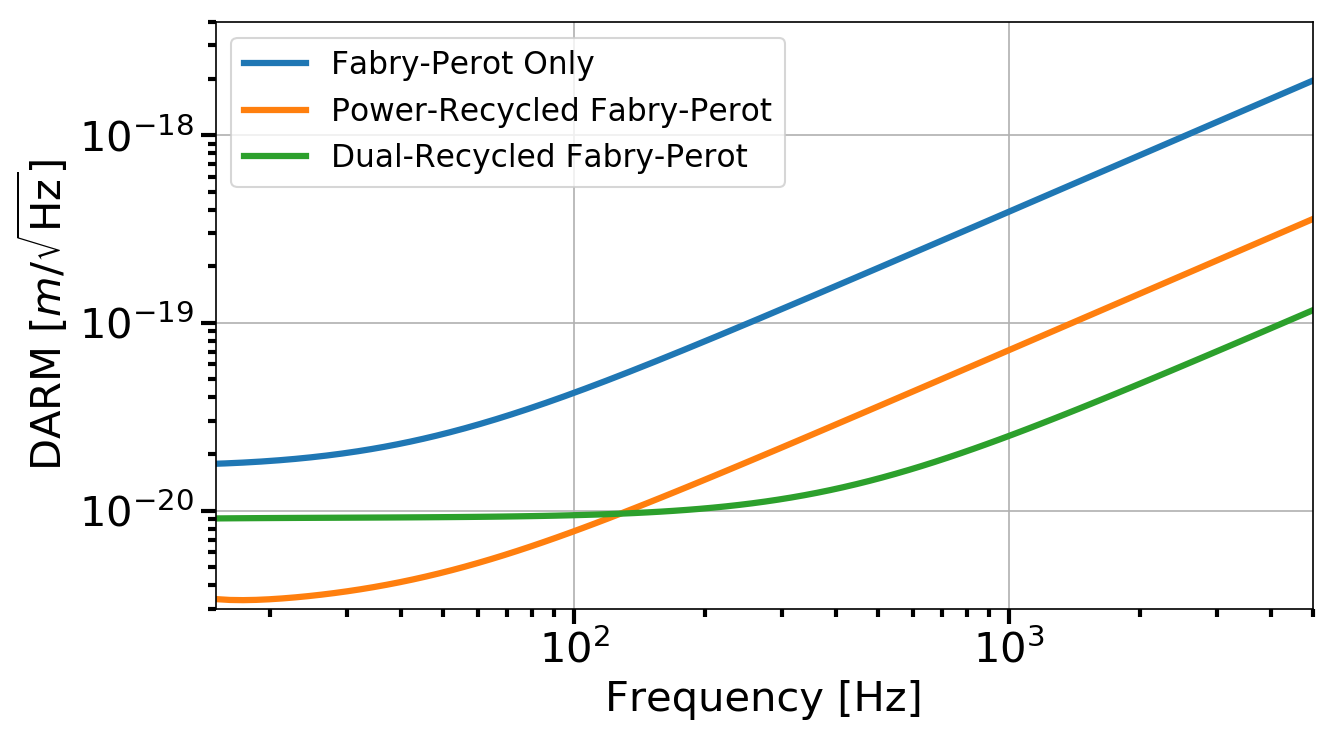

In [24]:
pl.figure(figsize=(9, 5), dpi=150)

pl.subplot(111)


pl.loglog(out2.x,4e3*out2['NSR_without_RP'],label='Fabry-Perot Only',linewidth=lw)
pl.loglog(out1.x,4e3*out1['NSR_without_RP'],label='Power-Recycled Fabry-Perot',linewidth=lw)
pl.loglog(out3.x,4e3*out3['NSR_without_RP'],label='Dual-Recycled Fabry-Perot',linewidth=lw)

pl.legend(fontsize=15)

pl.xlim(out.x.min(),out.x.max())
pl.xlabel("Frequency [Hz]",fontsize=20)
pl.ylabel("DARM [$m/\\sqrt{\mathrm{Hz}}$]",fontsize=20)
#pl.title('Shot Noise Limited Differential Arm Sensitivity',fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.xlim(15,5000)
pl.ylim(3e-21,4e-18)

pl.tight_layout()

pl.savefig('../../../Figures/SN_Lim_Sense.png')

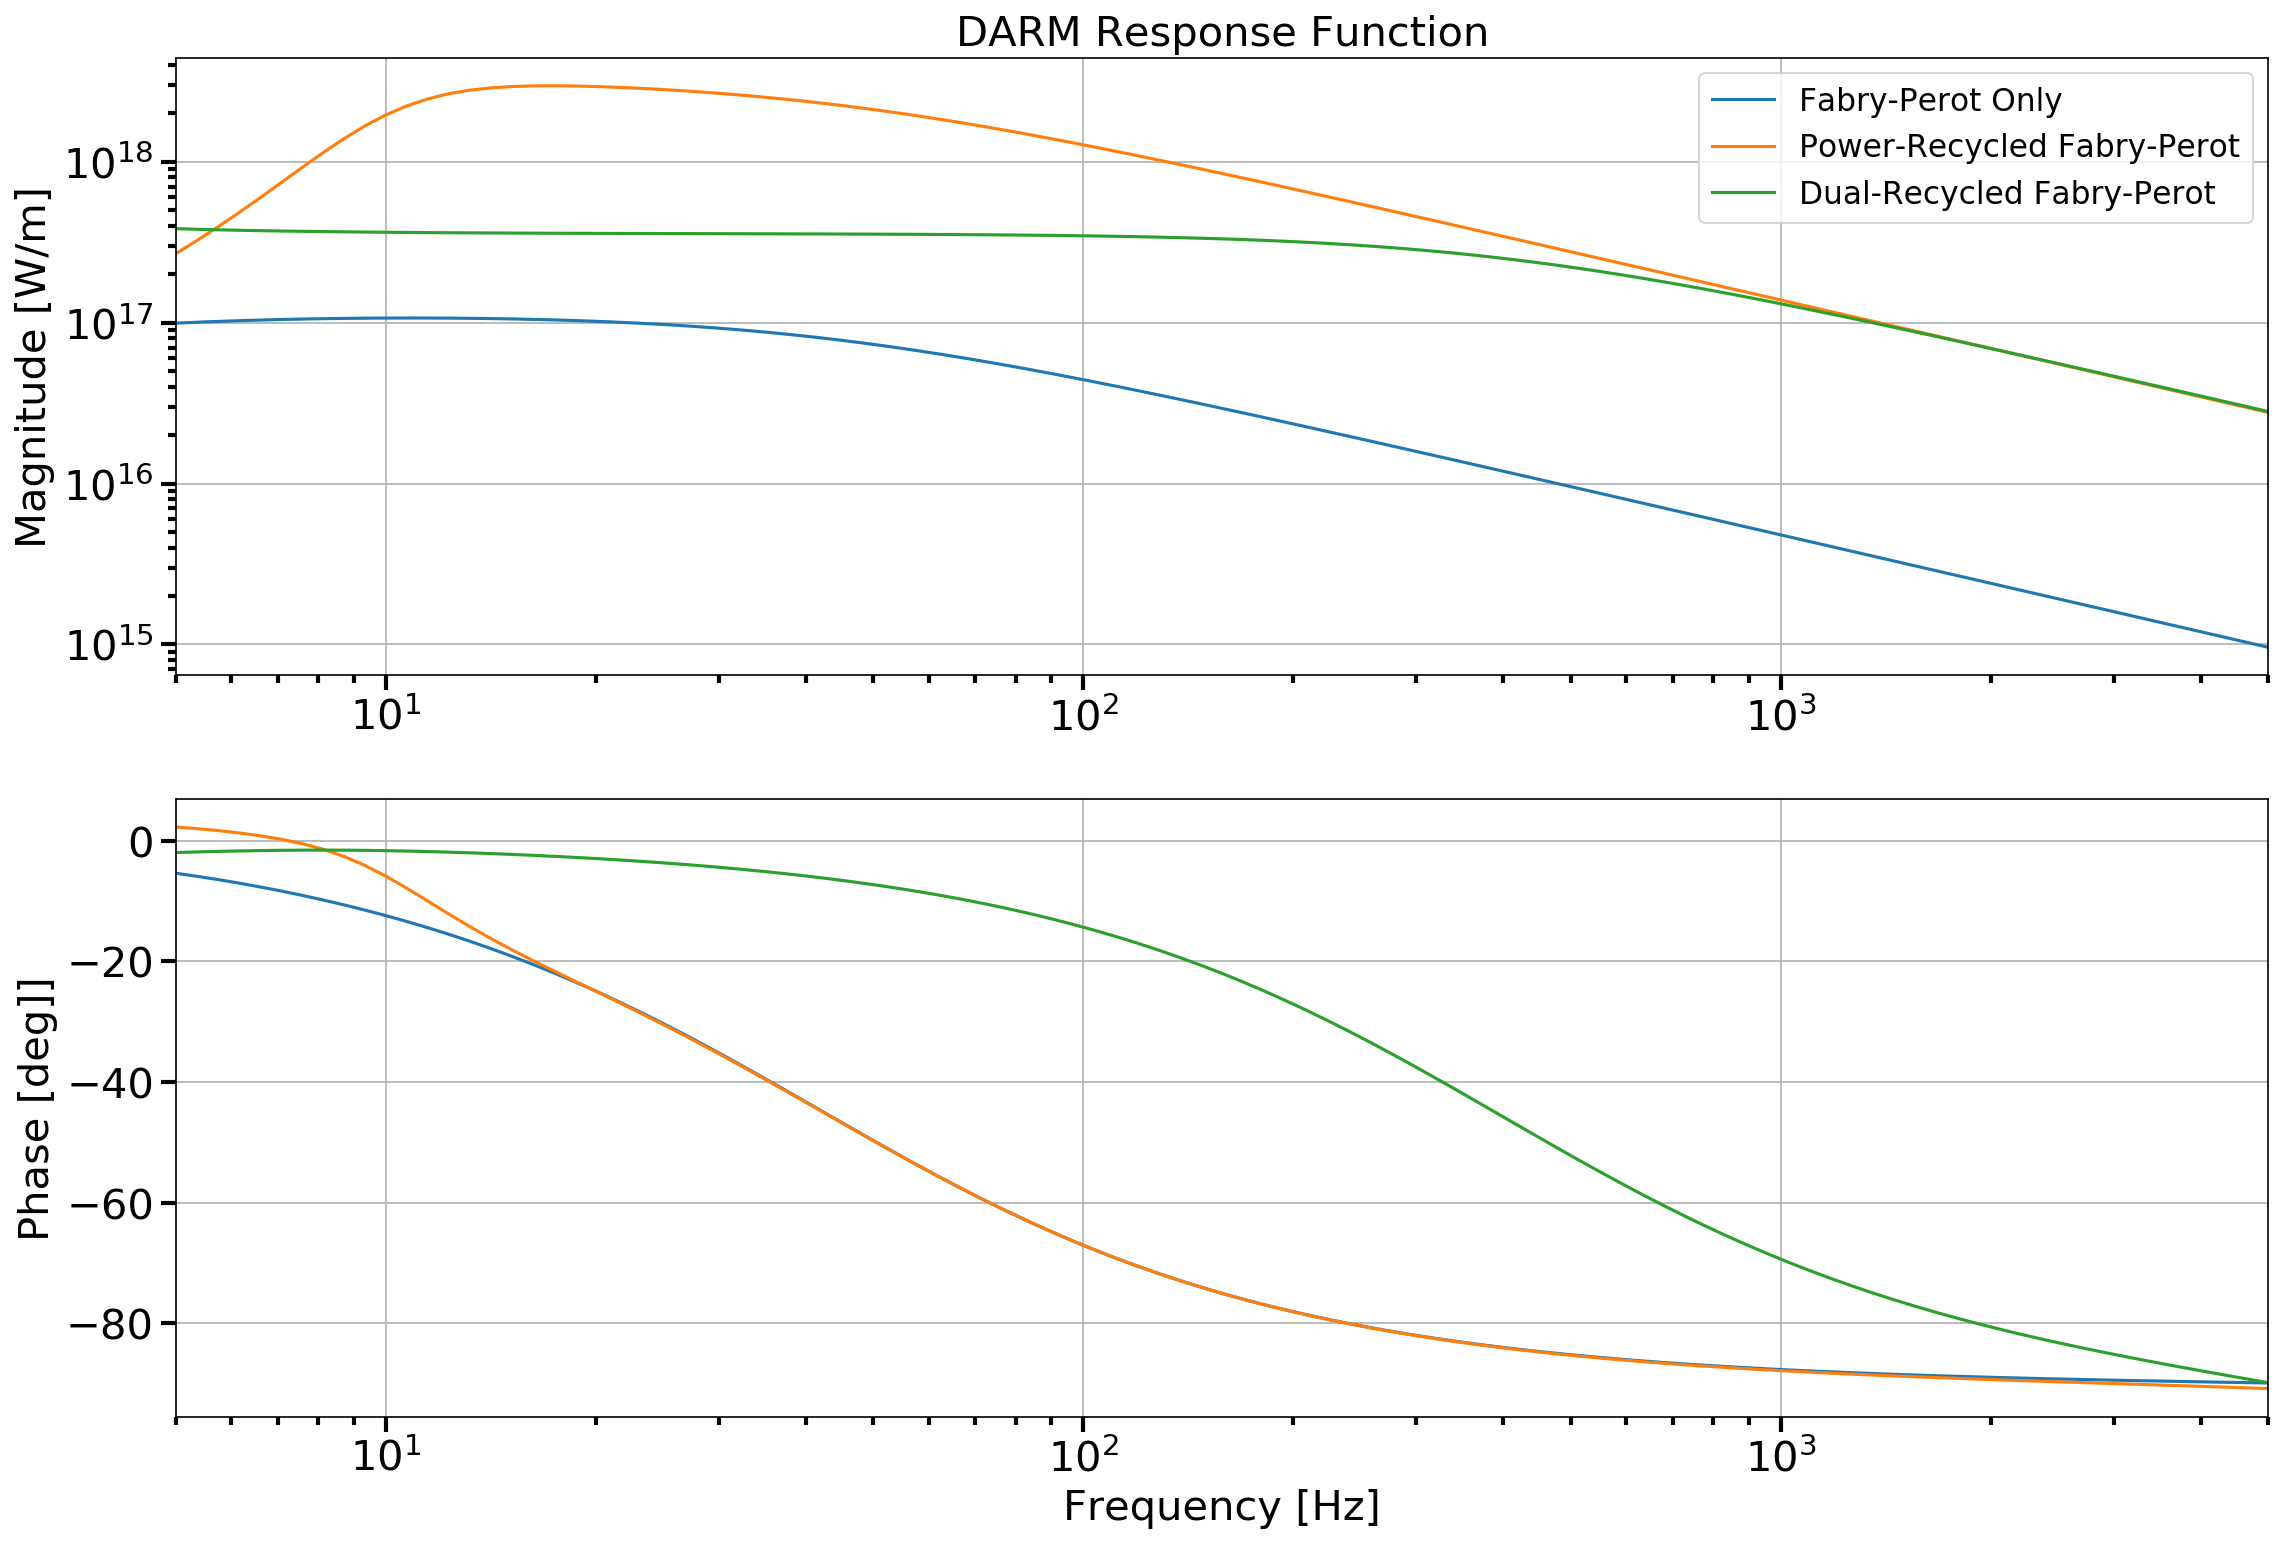

In [11]:
pl.figure(figsize=(18, 12), dpi=150)

pl.subplot(211)
pl.title("DARM Response Function",fontsize=20)
#pl.loglog(out.x,4.e3*np.abs(out['pdAS']),label='Dual-Recycled Fabry-Perot')
pl.loglog(out2.x,4.e3*np.abs(out2['pdAS']),label='Fabry-Perot Only')
pl.loglog(out1.x,4.e3*np.abs(out1['pdAS']),label='Power-Recycled Fabry-Perot')
pl.loglog(out3.x,4.e3*np.abs(out3['pdAS']),label='Dual-Recycled Fabry-Perot')
#pl.loglog(out4.x,4e3*out4['pdAS'],label='aLIGO Design + 10db Sqz + FC')

pl.legend(fontsize=15)

pl.xlim(out.x.min(),out.x.max())
pl.ylabel("Magnitude [W/m]",fontsize=20)

###Main plot formatting
#pl.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)


pl.subplot(212)

pl.semilogx(out2.x,np.angle(out2['pdAS'])*(180.0/np.pi)-180.0,label='Fabry-Perot Only')
pl.semilogx(out1.x,np.angle(out1['pdAS'])*(180.0/np.pi),label='Power-Recycled Fabry-Perot')
pl.semilogx(out3.x,np.angle(out3['pdAS'])*(180.0/np.pi),label='Dual-Recycled Fabry-Perot')


pl.xlabel("Frequency [Hz]",fontsize=20)
pl.ylabel("Phase [deg]]",fontsize=20)

###Main plot formatting
pl.tick_params(labelsize=20)
pl.tick_params(which='both', width=2)
pl.tick_params(which='major', length=7)
pl.tick_params(which='minor', length=4)
pl.grid(True, zorder=-1)
pl.xlim(out.x.min(),out.x.max())

pl.savefig('../../../Figures/Darm_Resp_Func.png')
pl.show()